In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy.special import logit, expit

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [2]:
# load data
df = pd.read_csv('/home/gigan/Documents/Spreadsheets/auto_wordle_scores.csv')
df.head()

,Date_Time,Name,Game,PuzzleNum,FinalScore,Answer,ScrabblePoints
0,2021-12-31 10:46:00,David Murphy,Wordle,195,6,unify,11.0
1,2021-12-31 10:47:00,Karen Waitz,Wordle,195,6,unify,11.0
2,2021-12-31 11:02:00,Stephen Sherwood,Wordle,195,3,unify,11.0
3,2021-12-31 13:46:00,Harry Waitz,Wordle,195,5,unify,11.0
4,2022-01-01 11:58:00,Stephen Sherwood,Wordle,196,5,rebus,7.0


In [3]:
# limit to the puzzle in which we last have words (396)
df2 = df[ df['PuzzleNum'] != 396].copy()
# convert all Xs to 7
df2['FinalScore'] = np.where((df2.FinalScore == 'X'),'6',df2.FinalScore)
# impute missing scrabble points to be zero
#df2['ScrabblePoints'] = df2['ScrabblePoints'].fillna(0)
# convert dtypes
df2 = df2.astype({
    'Date_Time': 'datetime64', 
    'FinalScore': 'int64', 
    #'ScrabblePoints': 'int64'
})
#create number of fails
df2['Fails'] = df2['FinalScore'] - 1

In [4]:
df2

,Date_Time,Name,Game,PuzzleNum,FinalScore,Answer,ScrabblePoints,Fails
0,2021-12-31 10:46:00,David Murphy,Wordle,195,6,unify,11.0,5
1,2021-12-31 10:47:00,Karen Waitz,Wordle,195,6,unify,11.0,5
2,2021-12-31 11:02:00,Stephen Sherwood,Wordle,195,3,unify,11.0,2
3,2021-12-31 13:46:00,Harry Waitz,Wordle,195,5,unify,11.0,4
4,2022-01-01 11:58:00,Stephen Sherwood,Wordle,196,5,rebus,7.0,4
...,...,...,...,...,...,...,...,...
1132,2022-08-12 08:26:00,David Murphy,Wordle,419,5,NaN,NaN,4
1133,2022-08-12 08:35:00,Harry Waitz,Wordle,419,5,NaN,NaN,4
1134,2022-08-12 10:16:00,Kara Sherwood,Wordle,419,4,NaN,NaN,3
1135,2022-08-12 10:42:00,Stephen Sherwood,Wordle,419,4,NaN,NaN,3


In [5]:
name_factor, player_names = pd.factorize(df2['Name'])

In [6]:
coords = {"obs": df2.index.values,  "player_names": player_names}

## Model 0 - so far the best model

In [7]:
with pm.Model(coords=coords) as BB_model0:
    # hyperprior
    Hα = pm.Gamma("Hα", alpha=3, beta=3) 
    Hβ = pm.Gamma("Hβ", alpha=3, beta=3) 
    # prior
    Θα = pm.Poisson("Θα", mu=Hα, dims="player_names")
    Θβ = pm.Poisson("Θβ", mu=Hβ, dims="player_names")
    
    # likelihood
    Fails = pm.BetaBinomial("Fails", n=6, alpha=Θα[name_factor], beta=Θβ[name_factor], observed=df2["Fails"].values, dims="obs")

In [8]:
with BB_model0:
    trace0 = pm.sample(
        2000,
        tune=2000,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Hα, Hβ]
>CompoundStep
>>Metropolis: [Θα]
>>Metropolis: [Θβ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8819, but should be close to 0.8. Try to increase the number of tuning steps.


## Model 1

In [40]:
with pm.Model(coords=coords) as BB_model1:
    # hyperprior
    Hα = pm.Gamma("Hα", alpha=3, beta=3) 
    Hβ = pm.Gamma("Hβ", alpha=3, beta=3) 
    Ηϵ = pm.Gamma("Ηϵ", alpha=3, beta=3)
    # error
    ϵ = pm.Poisson("ϵ", mu=Ηϵ)
    # prior
    Θα = pm.Poisson("Θα", mu=Hα, dims="player_names")
    Θβ = pm.Poisson("Θβ", mu=Hβ, dims="player_names")
    
    # likelihood
    Fails = pm.BetaBinomial("Fails", n=6, alpha=Θα[name_factor] + ϵ, beta=Θβ[name_factor] + ϵ, observed=df2["Fails"].values, dims="obs")

In [41]:
with BB_model1:
    trace1 = pm.sample(
        2000,
        tune=2000,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Hα, Hβ, Ηϵ]
>CompoundStep
>>Metropolis: [ϵ]
>>Metropolis: [Θα]
>>Metropolis: [Θβ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


## Compare

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

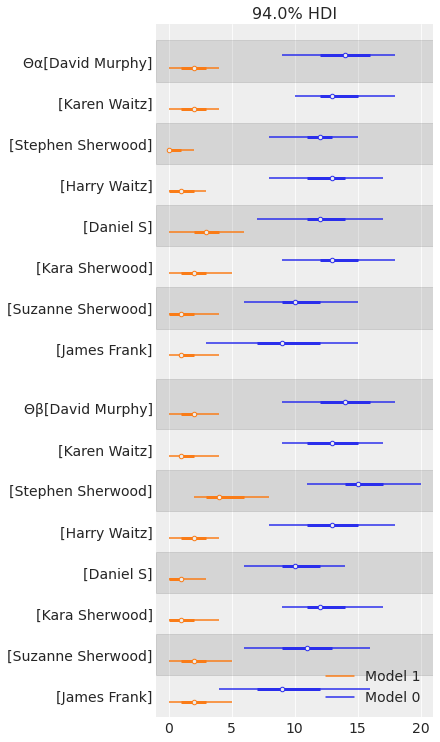

In [42]:
az.plot_forest([trace0, trace1], var_names=['Θα', 'Θβ'], combined=True)

In [43]:
az.waic(trace0)

Computed from 8000 posterior samples and 1132 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1698.42    10.10
p_waic        4.76        -

In [44]:
az.waic(trace1)

Computed from 8000 posterior samples and 1132 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1677.42    11.09
p_waic        3.13        -

In [45]:
az.compare({'BB': trace0, 'BB2': trace1}, 'waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
BB2,0,-1677.415952,3.134062,0.000000,1.0,11.093610,0.000000,False,log
BB,1,-1698.419407,4.758496,21.003455,0.0,10.098243,1.799642,False,log


In [47]:
az.summary(trace0, var_names=['Θα', 'Θβ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Θα[David Murphy],14.060,2.489,9.0,18.0,0.407,0.290,37.0,139.0,1.10
Θα[Karen Waitz],13.503,2.498,10.0,18.0,0.254,0.180,97.0,193.0,1.04
Θα[Stephen Sherwood],11.911,2.021,8.0,15.0,0.158,0.112,166.0,400.0,1.04
Θα[Harry Waitz],12.726,2.558,8.0,17.0,0.300,0.213,71.0,122.0,1.05
Θα[Daniel S],12.448,2.710,7.0,17.0,0.258,0.183,107.0,200.0,1.02
Θα[Kara Sherwood],13.488,2.470,9.0,18.0,0.399,0.285,35.0,127.0,1.08
Θα[Suzanne Sherwood],10.487,2.596,6.0,15.0,0.267,0.190,106.0,491.0,1.05
Θα[James Frank],9.313,3.468,3.0,15.0,0.132,0.099,776.0,1070.0,1.01
Θβ[David Murphy],13.923,2.514,9.0,18.0,0.403,0.287,36.0,155.0,1.10
Θβ[Karen Waitz],12.989,2.369,9.0,17.0,0.239,0.170,98.0,225.0,1.04
